In [1]:
# Import Required Libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [3]:
# Because we are dealing with time series data and we will need the datetime data to recognize a particular record so we convert 
# datetime into index of dataframe.
fpath = 'DOM_hourly.csv'
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [4]:
#checking shape of dataframe
df.shape

(116189, 1)

In [5]:
#checking missing data
df.isna().sum()

DOM_MW    0
dtype: int64

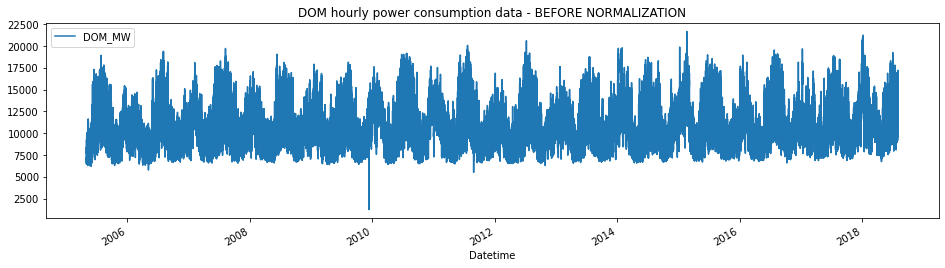

In [6]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

In [7]:
# Normalize data
# Before proceeding with further data analysis we must ensure that the data is normalized.

def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(116189, 1)

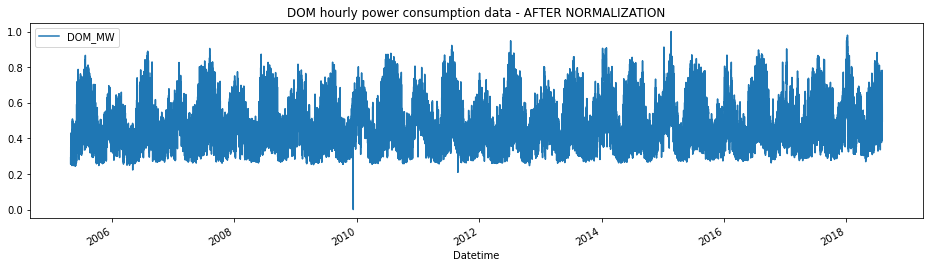

In [8]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

##### After normalization the range of power consumption values changes which we can observe on the y-axis of the graph. In the earlier graph that was displayed it was in the range 0 - 22500.
##### Now after normalization we can observe that the data range on y-axis is 0.0 - 1.0.

In [9]:
df_norm.shape

(116189, 1)

### Prepare data for training the RNN models

In [12]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
        
        
        
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [13]:
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


## Build a SIMPLE RNN model

In [14]:
rnn_model = Sequential()

# activation function used in the layer is the hyperbolic tangent.
# return_sequences=True argument indicates that the layer will return the full sequence of outputs instead of just the last output.
# X_train.shape[1] represents the number of time steps in the input sequence, and 1 represents the number of features at each time step.
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
# Dropout is a regularization technique that randomly sets a fraction of input units to 0 during training to prevent overfitting. 
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 dropout_1 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 4

In [15]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 13s 95ms/step - loss: 0.1342
Epoch 2/10
110/110 [==============================] - 11s 97ms/step - loss: 0.0312
Epoch 3/10
110/110 [==============================] - 11s 98ms/step - loss: 0.0157
Epoch 4/10
110/110 [==============================] - 11s 99ms/step - loss: 0.0101
Epoch 5/10
110/110 [==============================] - 11s 98ms/step - loss: 0.0075
Epoch 6/10
110/110 [==============================] - 11s 98ms/step - loss: 0.0060
Epoch 7/10
110/110 [==============================] - 11s 98ms/step - loss: 0.0050
Epoch 8/10
110/110 [==============================] - 11s 98ms/step - loss: 0.0044
Epoch 9/10
110/110 [==============================] - 11s 98ms/step - loss: 0.0039
Epoch 10/10
110/110 [==============================] - 11s 99ms/step - loss: 0.0035


In [16]:
# Let's check r2 score for the values predicted by the above trained SIMPLE RNN model
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

193/193 [==============================] - 1s 3ms/step
R2 Score of RNN model =  0.9401416809833812


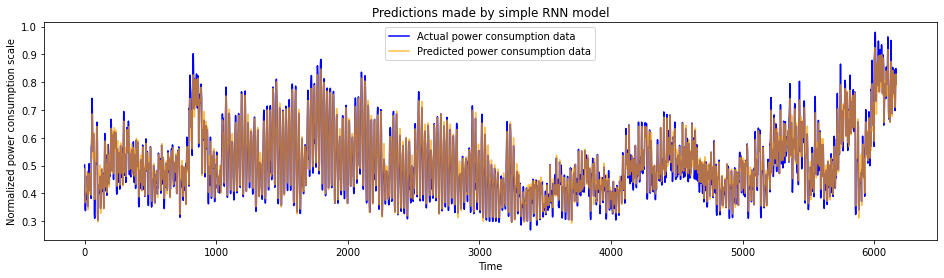

In [17]:
# Let's compare the actual values vs predicted values by plotting a graph
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

## Build an LSTM model

In [18]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 40)            6720      
                                                                 
 dropout_3 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 40)            12960     
                                                                 
 dropout_4 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [19]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 32s 253ms/step - loss: 0.0255
Epoch 2/10
110/110 [==============================] - 26s 238ms/step - loss: 0.0120
Epoch 3/10
110/110 [==============================] - 26s 237ms/step - loss: 0.0089
Epoch 4/10
110/110 [==============================] - 26s 237ms/step - loss: 0.0053
Epoch 5/10
110/110 [==============================] - 26s 238ms/step - loss: 0.0043
Epoch 6/10
110/110 [==============================] - 26s 236ms/step - loss: 0.0033
Epoch 7/10
110/110 [==============================] - 28s 255ms/step - loss: 0.0026
Epoch 8/10
110/110 [==============================] - 27s 246ms/step - loss: 0.0022
Epoch 9/10
110/110 [==============================] - 28s 255ms/step - loss: 0.0020
Epoch 10/10
110/110 [==============================] - 26s 233ms/step - loss: 0.0019


In [20]:
# Let's check r2 score for the values predicted by the above trained LSTM model
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

193/193 [==============================] - 3s 7ms/step
R^2 Score of LSTM model =  0.9485613653194658


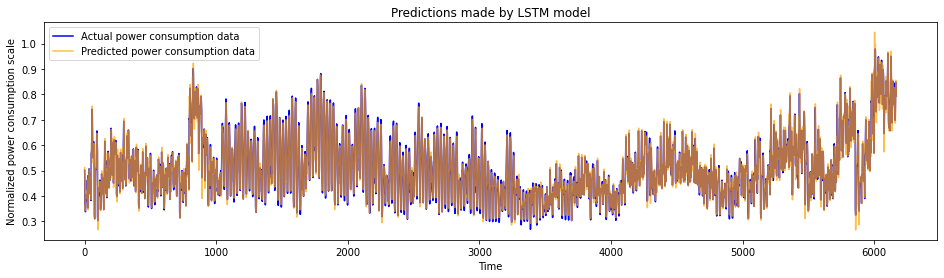

In [21]:
# Let's compare the actual values vs predicted values by plotting a graph
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")